In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import spacy
from spacytextblob.spacytextblob import SpacyTextBlob # sentiment analysis

from  nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [2]:
# !pip install spacymoji
from spacymoji import Emoji # deal with emojis

# !pip install emot --upgrade
# https://github.com/NeelShah18/emot
import emot

## Import Data

In [3]:
scrape = pd.read_csv('../data/pre_nlp_data.csv')

In [4]:
titles = scrape.iloc[:,0:4]

**Note** For NLP, we only care about the titles and scores, so create a dataframe for that.

In [5]:
# will be used for plotting pos counts alongside pos percents
def pos_dual_plot(var1, var2):
    fig, ax = plt.subplots(1, 2, figsize = (15,5))

    # first regplot
    sns.regplot(x=var1, y='num_comments_logscale', data = pos_df,
                        scatter_kws={'alpha': 0.2,
                                     'color': 'rebeccapurple'},
                        line_kws={'color': 'red'},
                        ax=ax[0])

    # fluff
    ax[0].set_title(var1+' vs Num Comments Log Scale')
    ax[0].set_xlabel(var1)
    ax[0].set_ylabel('Frequency (log scale)');

    # second regplot
    sns.regplot(x=var2, y='num_comments_logscale', data = pos_df,
                        scatter_kws={'alpha': 0.2,
                                     'color': 'dodgerblue'},
                        line_kws={'color': 'red'},
                        ax=ax[1])

    # fluff
    ax[1] = plt.gca()
    ax[1].set_title(var2+' vs Num Comments Log Scale')
    ax[1].set_xlabel(var2)
    ax[1].set_ylabel('Frequency (log scale)');

## NLP - Spacy

In [6]:
# add sentiment and emoji capabilities to our spacy pipeline
nlp = spacy.load('en_core_web_sm')
nlp.add_pipe('spacytextblob')
nlp.add_pipe("emoji")

In [7]:
titles['docs'] = titles['title'].map(lambda x: nlp(x))

### Add Sentiment Scores

In [8]:
titles['polarity'] = titles['docs'].map(lambda x: x._.polarity)

In [9]:
titles['subjectivity'] = titles['docs'].map(lambda x: x._.subjectivity)

#### Review `polarity`

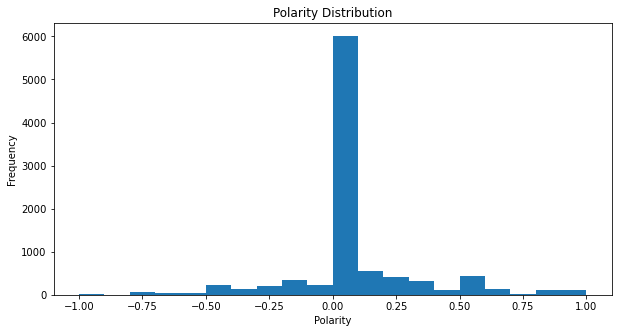

In [10]:
fig, ax = plt.subplots(1,1,figsize=(10,5))

# histogram
ax.hist(titles.polarity, bins=20)

# fluff
ax.set_title('Polarity Distribution')
ax.set_xlabel('Polarity')
ax.set_ylabel('Frequency');

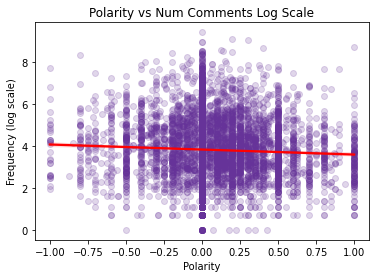

In [11]:
sns.regplot(x='polarity', y='num_comments_logscale', data = titles,
            scatter_kws={'alpha': 0.2,
                         'color': 'rebeccapurple'},
            line_kws={'color': 'red'})

# fluff
ax = plt.gca()
ax.set_title('Polarity vs Num Comments Log Scale')
ax.set_xlabel('Polarity')
ax.set_ylabel('Frequency (log scale)');

**Observation** This metric is pretty centered around the 0.00-0.10 band. It is not clear if it is useful but let's keep it for modeling.

#### Review `subjectivity`

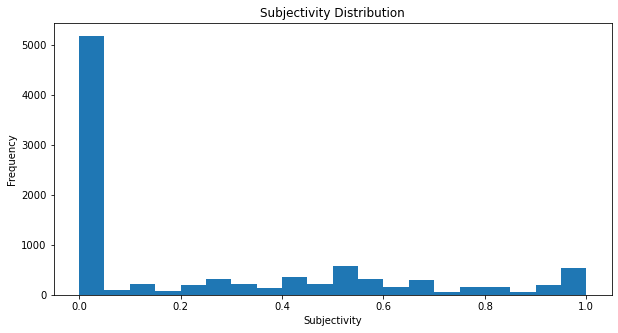

In [12]:
fig, ax = plt.subplots(1,1,figsize=(10,5))

# histogram
ax.hist(titles.subjectivity, bins=20)

# fluff
ax.set_title('Subjectivity Distribution')
ax.set_xlabel('Subjectivity')
ax.set_ylabel('Frequency');

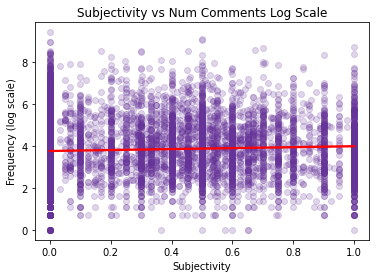

In [13]:
sns.regplot(x='subjectivity', y='num_comments_logscale', data = titles,
            scatter_kws={'alpha': 0.2,
                         'color': 'rebeccapurple'},
            line_kws={'color': 'red'})

# fluff
ax = plt.gca()
ax.set_title('Subjectivity vs Num Comments Log Scale')
ax.set_xlabel('Subjectivity')
ax.set_ylabel('Frequency (log scale)');

**Observation** Similar to `polarity`, `subjectivity` is a mixed bag for usefulness at a high-level. Continue to keep for modeling.

### Add emojis fields

Reddit posts can contain emojis. Spacymoji is a library that can assist in understanding their presence and counts

In [14]:
# create flag for if a title has an emoji
titles['has_emoji'] = titles['docs'].map(lambda x: x._.has_emoji)

In [15]:
# add the number of emoji in title
titles['number_of_emoji'] = titles['docs'].map(lambda x: len(x._.emoji))

In [16]:
titles.head()

,num_comments,num_comments_logscale,target,title,docs,polarity,subjectivity,has_emoji,number_of_emoji
0,2008,7.605392,1,I got new teeth today after having bad teeth m...,"(I, got, new, teeth, today, after, having, bad...",-0.104545,0.507071,False,0
1,440,6.089045,1,My avocado today was 11/10.,"(My, avocado, today, was, 11/10, .)",0.000000,0.000000,False,0
2,1855,7.526179,1,Husband of teacher killed in Texas school shoo...,"(Husband, of, teacher, killed, in, Texas, scho...",-0.200000,0.000000,False,0
3,2637,7.877776,1,Twitter shareholder sues Elon Musk for tanking...,"(Twitter, shareholder, sues, Elon, Musk, for, ...",0.000000,0.000000,False,0
4,418,6.037871,1,Valtteri giving his last print to Lewis,"(Valtteri, giving, his, last, print, to, Lewis)",0.000000,0.066667,False,0


`has_emoji` and `number_of_emoji` appropriately added.

#### Review `has_emoji`

In [17]:
titles.has_emoji.value_counts(normalize=True)

False    0.946184
True     0.053816
Name: has_emoji, dtype: float64

This is super close to 95% penetration and not being useful. Take a look at the target breakout.

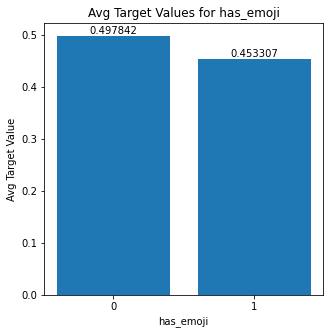

In [18]:
fig, ax = plt.subplots(1,1,figsize=(5,5))

# bar graph for average target by value
ax.bar(titles.groupby('has_emoji').mean().index,
       height = titles.groupby('has_emoji').mean().target)

# fluff
ax.bar_label(ax.containers[0])
ax.set_xticks([0,1])
ax.set_title('Avg Target Values for has_emoji')
ax.set_xlabel('has_emoji')
ax.set_ylabel('Avg Target Value');

**Observation** Almost a 5% difference in average `target` value based on `has_emoji`. Keep this variable for modeling.

#### Review `number_of_emoji`

In [19]:
titles.number_of_emoji.value_counts(normalize=True)

0     0.946184
1     0.038530
2     0.008271
3     0.003979
4     0.001361
5     0.000733
8     0.000419
7     0.000314
12    0.000209
Name: number_of_emoji, dtype: float64

Similar to `has_emoji`, this is super close to 95% penetration and not being useful. Take a look at the target breakout.

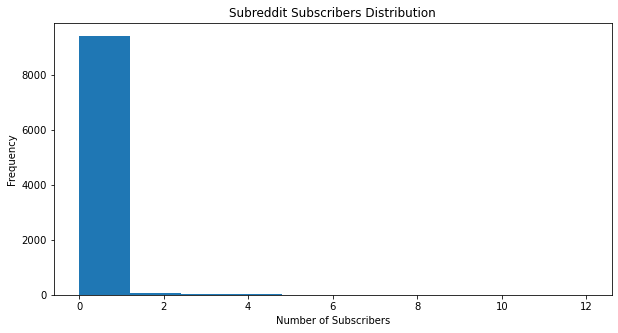

In [20]:
fig, ax = plt.subplots(1,1,figsize=(10,5))

# histogram
ax.hist(titles.number_of_emoji)

# fluff
ax.set_title('Subreddit Subscribers Distribution')
ax.set_xlabel('Number of Subscribers')
ax.set_ylabel('Frequency');

**Observation** This basically as surrogate for `has_emoji`. Since the value for 1 emoji is so small, <4%, drop this variable and stick to `has_emoji` only.

In [21]:
titles.drop('has_emoji', axis=1, inplace=True)

#### Remove Emojis

Cleantext is a library that can remove the occurrences of emoji from the titles. This will be helpful for cleaner data during lemmatization and stemming.

In [22]:
# !pip install clean-text
# https://www.educative.io/edpresso/how-to-remove-emoji-from-the-text-in-python
from cleantext import clean

In [23]:
titles['title'] = titles['title'].map(lambda x: clean(x, no_emoji=True))

### Text Smileys

emot is library that is useful for identifying emoticons within strings of text. Since people use emojis and emoticons somewhat interchangeably, look into the impact of emoticons in a title.

In [24]:
# see github link by import emot
emot_obj = emot.core.emot()

In [25]:
titles['has_emoticon'] = titles['title'].map(lambda x: emot_obj.emoticons(x)['flag'])
titles['number_of_emoticons'] = titles['title'].map(lambda x: len(emot_obj.emoticons(x)['value']))

In [26]:
titles.head()

,num_comments,num_comments_logscale,target,title,docs,polarity,subjectivity,number_of_emoji,has_emoticon,number_of_emoticons
0,2008,7.605392,1,i got new teeth today after having bad teeth m...,"(I, got, new, teeth, today, after, having, bad...",-0.104545,0.507071,0,False,0
1,440,6.089045,1,my avocado today was 11/10.,"(My, avocado, today, was, 11/10, .)",0.000000,0.000000,0,False,0
2,1855,7.526179,1,husband of teacher killed in texas school shoo...,"(Husband, of, teacher, killed, in, Texas, scho...",-0.200000,0.000000,0,False,0
3,2637,7.877776,1,twitter shareholder sues elon musk for tanking...,"(Twitter, shareholder, sues, Elon, Musk, for, ...",0.000000,0.000000,0,False,0
4,418,6.037871,1,valtteri giving his last print to lewis,"(Valtteri, giving, his, last, print, to, Lewis)",0.000000,0.066667,0,False,0


`has_emoticon` and `number_of_emoticons` appropriately added.

#### Review `has_emoticon`

In [27]:
titles.has_emoticon.value_counts(normalize=True)

False    0.988902
True     0.011098
Name: has_emoticon, dtype: float64

In [28]:
# too many False values. Drop it
titles.drop('has_emoticon', axis=1, inplace=True)

#### Review `number of emoticons`

In [29]:
titles.number_of_emoticons.value_counts(normalize=True)

0    0.988902
1    0.011098
Name: number_of_emoticons, dtype: float64

In [30]:
# too many zero values. Drop it
titles.drop('number_of_emoticons', axis=1, inplace=True)

**Note** cleaning our titles of emoticons is not necessary since they are usually comprised of punctuation. TF-IDF vectorization will include these.

### Parts of Speech counts

In [31]:
# convert our titles into their parts of speech
pos_lst = [[w.pos_ for w in nlp(t)] for t in titles.loc[:,'title']]

In [32]:
# For each available part of speech (stored here in pos_parts) get the count 
# of that pos by title
# https://stackoverflow.com/questions/722697/best-way-to-turn-word-list-into-frequency-dict
pos_parts = ['ADJ','ADP','ADV','AUX','CONJ','CCONJ','DET','INTJ','NOUN','NUM'\
             ,'PART','PRON','PROPN','PUNCT','SCONJ','SYM','VERB','X','SPACE']

pos_counts = [{i:pos_lst[t].count(i) for i in pos_parts} for t in range(len(pos_lst))]


In [33]:
# convert those counts by title into a dataframe
pos_df = pd.DataFrame(pos_counts)

# add a total sum of pos column
pos_df = pos_df.join(pos_df.sum(axis=1).rename("sum_pos"))

In [34]:
pos_df.sum().sort_values(ascending=True)

CONJ           0
SPACE          0
SYM          333
INTJ         497
X            917
SCONJ       1436
CCONJ       1722
NUM         2113
PART        2566
ADV         3779
AUX         4853
DET         6684
PROPN       6906
ADJ         6913
ADP         8257
PRON        8606
PUNCT      10774
VERB       11363
NOUN       21702
sum_pos    99421
dtype: int64

**Note** `CONJ` and `SPACE` do not show up in our dataframe. Drop them.

In [35]:
# drop conj, space
pos_df.drop(['SPACE','CONJ'], axis = 1, inplace = True)

In [36]:
# join pos_df with our titles dataframe
pos_df = pos_df.join(titles[['num_comments','num_comments_logscale','target']])

In [37]:
pos_df.head()

,ADJ,ADP,ADV,AUX,CCONJ,DET,INTJ,NOUN,NUM,PART,...,PROPN,PUNCT,SCONJ,SYM,VERB,X,sum_pos,num_comments,num_comments_logscale,target
0,3,1,0,0,0,0,0,4,0,0,...,0,1,0,0,2,0,13,2008,7.605392,1
1,0,0,0,1,0,0,0,2,1,0,...,0,1,0,0,0,0,6,440,6.089045,1
2,0,3,0,0,0,0,0,6,0,0,...,1,0,0,0,2,0,12,1855,7.526179,1
3,0,1,0,0,0,1,0,4,0,1,...,2,0,0,0,2,0,11,2637,7.877776,1
4,1,1,0,0,0,0,0,2,0,0,...,0,0,0,0,2,0,7,418,6.037871,1


#### Add `pos` percentages

In [38]:
# in addition to counts, add the percent of the title that is each pos
# go column by column in pos_df and divide it by sum_pos to get the percent
pos_perc_df = pd.DataFrame(
                [pos_df.apply(lambda row: 0 if row.sum_pos == 0
                                          else row[col] / row.sum_pos
                                        , axis = 1)
                            for col in pos_df.columns[:-4]]).T

# update column titles to end with _percent except for last 4 cols
pos_perc_df.columns = [col+'_percent' for col in pos_df.columns[:-4]]

In [39]:
# join back to pos_df so we have counts and percentages
pos_df = pos_df.join(pos_perc_df)

#### Review `ADJ` and `ADJ_percent` (Adjective)

In [40]:
pos_df.ADJ.value_counts(normalize=True)

0     0.528008
1     0.314313
2     0.104073
3     0.031515
4     0.012669
5     0.004921
6     0.002094
7     0.001256
8     0.000733
11    0.000209
9     0.000105
10    0.000105
Name: ADJ, dtype: float64

**Observation** 48% of titles contain at least one `ADJ`

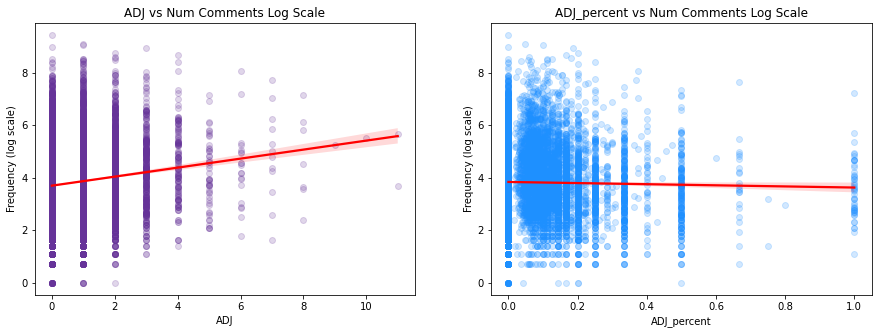

In [41]:
pos_dual_plot('ADJ', 'ADJ_percent')

**Observation** The number of `ADJ` is positively correlated with `num_comments_logscale` while `ADJ_percent` is more or less flat. Expect to see `ADJ` play a larger part during modeling.

#### Review `ADP` and `ADP_percent` (adposition)

In [42]:
# make sure there is enough density for ADP
pos_df.ADP.value_counts(normalize=True)

0     0.498063
1     0.297979
2     0.119987
3     0.044812
4     0.020521
5     0.009737
6     0.004188
7     0.002722
8     0.001256
9     0.000419
11    0.000209
10    0.000105
Name: ADP, dtype: float64

**Observation** 50% of titles contain at least one ADP

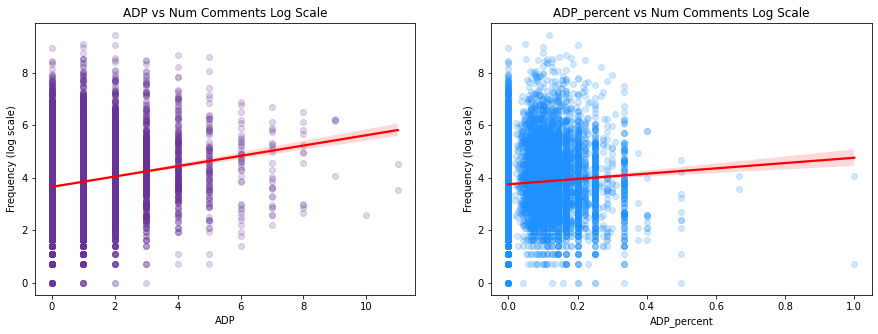

In [43]:
pos_dual_plot('ADP', 'ADP_percent')

**Observation** The number of `ADP` and `ADP_percent` are positively correlated with `num_comments_logscale`.

#### Review `ADV` and `ADV_percent` (adverb)

In [44]:
# make sure there is enough density for ADV
pos_df.ADV.value_counts(normalize=True)

0    0.726521
1    0.190451
2    0.056224
3    0.018741
4    0.005759
5    0.001361
6    0.000314
7    0.000314
8    0.000209
9    0.000105
Name: ADV, dtype: float64

**Observation** 27% of titles contain at least one ADV

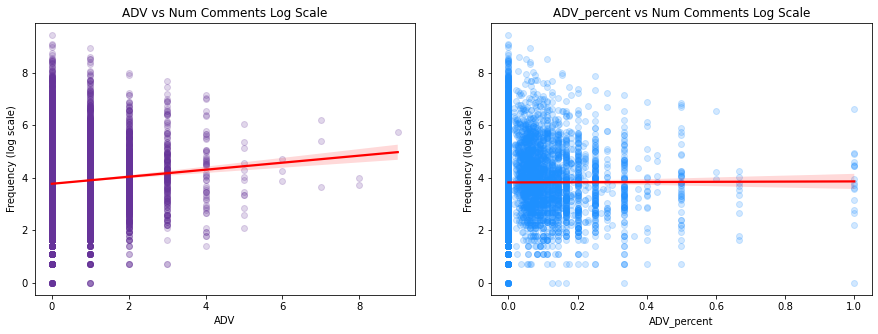

In [45]:
pos_dual_plot('ADV', 'ADV_percent')

**Observation** The number of `ADV` is positively correlated with `num_comments_logscale` while `ADV_percent` is more or less flat. Expect to see `ADV` play a larger part during modeling.

#### Review `AUX` and `AUX_percent` (auxiliary verb)

In [46]:
# make sure there is enough density for AUX
pos_df.AUX.value_counts(normalize=True)

0    0.654696
1    0.240498
2    0.067951
3    0.024500
4    0.007748
5    0.002513
6    0.001047
7    0.000419
9    0.000419
8    0.000209
Name: AUX, dtype: float64

**Observation** 34% of titles contain at least one AUX

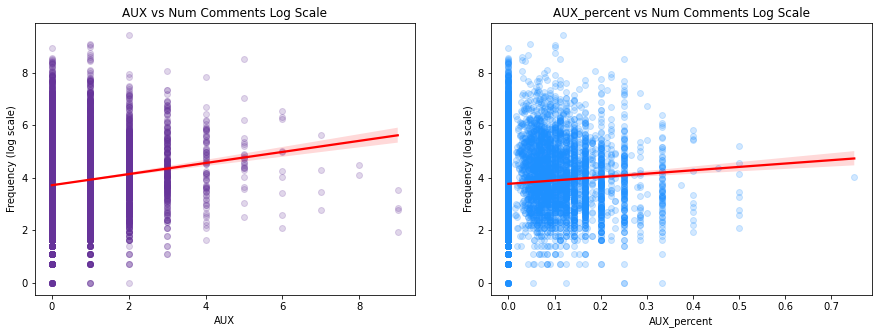

In [47]:
pos_dual_plot('AUX', 'AUX_percent')

**Observation** The number of `AUX` and `AUX_percent` are positively correlated with `num_comments_logscale`.

#### Review `CCONJ` and `CCONJ_percent` (coordinating conjunction)

In [48]:
# make sure there is enough density for CCONJ
pos_df.CCONJ.value_counts(normalize=True)

0    0.848602
1    0.128049
2    0.019265
3    0.002827
4    0.001047
5    0.000209
Name: CCONJ, dtype: float64

**Observation** 15% of titles contain at least one CCONJ

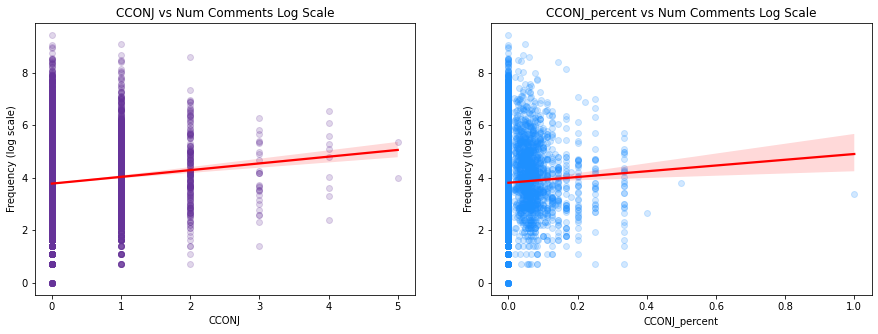

In [49]:
pos_dual_plot('CCONJ', 'CCONJ_percent')

**Observation** The number of `CCONJ` and `CCONJ_percent` are positively correlated with `num_comments_logscale`.

#### Review `DET` and `DET_percent` (determiner)

In [50]:
# make sure there is enough density for DET
pos_df.DET.value_counts(normalize=True)

0     0.550937
1     0.291593
2     0.104596
3     0.030782
4     0.011831
5     0.006387
6     0.002618
8     0.000524
7     0.000314
9     0.000209
23    0.000105
10    0.000105
Name: DET, dtype: float64

**Observation** 45% of titles contain at least one DET

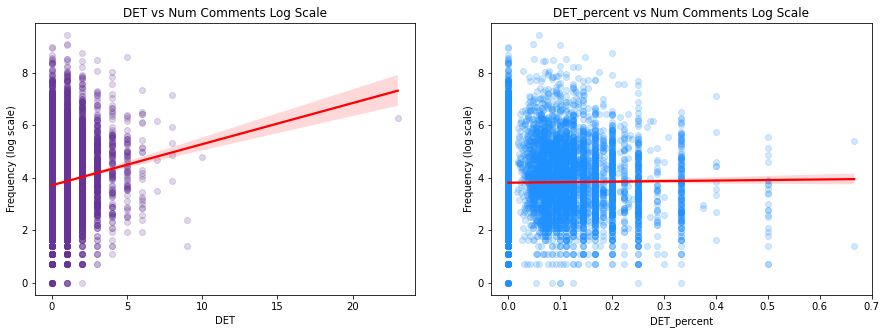

In [51]:
pos_dual_plot('DET', 'DET_percent')

**Observation** The number of `DET` is positively correlated with `num_comments_logscale` while `DET_percent` is more or less flat. Expect to see `DET` play a larger part during modeling.

#### Review `INTJ` and `INTJ_percent` (interjection)

In [52]:
# make sure there is enough density for INTJ
pos_df.INTJ.value_counts(normalize=True)

0     0.958329
1     0.033923
2     0.006491
3     0.000838
4     0.000209
11    0.000105
6     0.000105
Name: INTJ, dtype: float64

In [53]:
# too many zero values. drop it
pos_df.drop('INTJ', axis=1, inplace=True)

#### Review `NOUN` and `NOUN_percent` (noun)

In [54]:
# make sure there is enough density for NOUN
pos_df.NOUN.value_counts(normalize=True)

1     0.265627
2     0.222071
0     0.175793
3     0.134436
4     0.079468
5     0.043137
6     0.028374
7     0.019684
8     0.009842
10    0.005863
9     0.005235
11    0.003141
12    0.002618
13    0.001989
14    0.001256
16    0.000524
15    0.000524
17    0.000209
18    0.000105
19    0.000105
Name: NOUN, dtype: float64

**Observation** 84% of titles contain at least one noun!

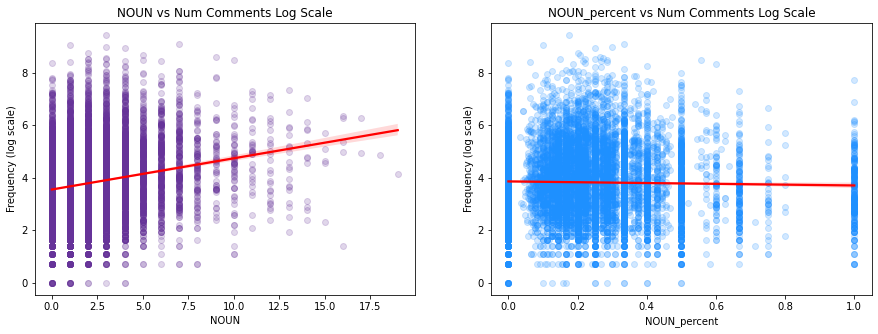

In [55]:
pos_dual_plot('NOUN', 'NOUN_percent')

**Observation** The number of `NOUN` is positively correlated with `num_comments_logscale` while `NOUN_percent` is slightly negatively correlated. Both could play part in modeling.

#### Review `NUM` and `NUM_percent` (numeral)

In [56]:
# make sure there is enough density for NUM
pos_df.NUM.value_counts(normalize=True)

0     0.846299
1     0.115066
2     0.024291
3     0.008481
4     0.002722
5     0.001361
6     0.000524
9     0.000419
7     0.000314
8     0.000209
11    0.000209
13    0.000105
Name: NUM, dtype: float64

**Observation** 15% of titles contain at least one NUM

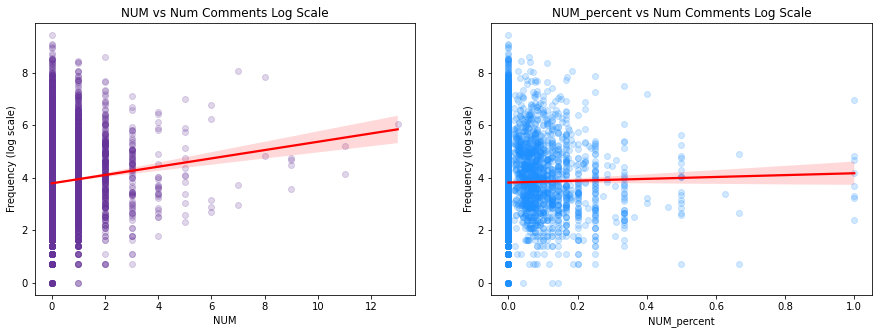

In [57]:
pos_dual_plot('NUM', 'NUM_percent')

**Observation** The number of `NUM` is positively correlated with `num_comments_logscale` while `NUM_percent` is more or less flat. Expect to see `NUM` play a larger part during modeling.

#### Review `PART` and `PART_percent` (particle)

In [58]:
# make sure there is enough density for PART
pos_df.PART.value_counts(normalize=True)

0    0.784525
1    0.174223
2    0.032353
3    0.006387
4    0.001989
5    0.000524
Name: PART, dtype: float64

**Observation** 21% of titles contain at least one PART

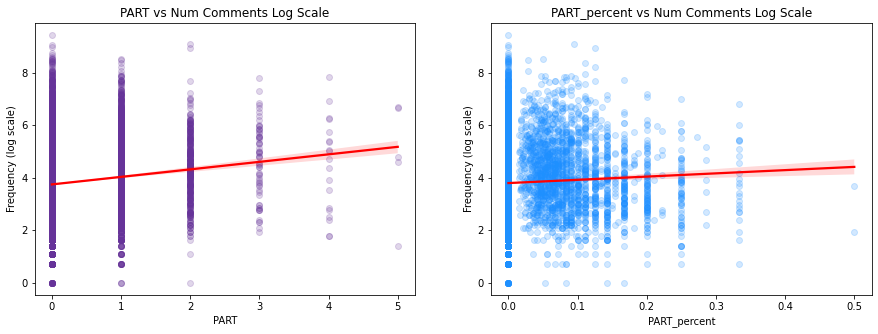

In [59]:
pos_dual_plot('PART', 'PART_percent')

**Observation** The number of `PART` is positively correlated with `num_comments_logscale` while `PART_percent` is more or less flat. Expect to see `PART` play a larger part during modeling.

#### Review `PRON` and `PRON_percent` (pronoun)

In [60]:
# make sure there is enough density for PRON
pos_df.PRON.value_counts(normalize=True)

0     0.528322
1     0.252434
2     0.116532
3     0.051513
4     0.026594
5     0.011203
6     0.005759
7     0.003665
8     0.001675
10    0.001152
11    0.000419
12    0.000419
13    0.000105
15    0.000105
9     0.000105
Name: PRON, dtype: float64

**Observation** 47% of titles contain at least one PRON

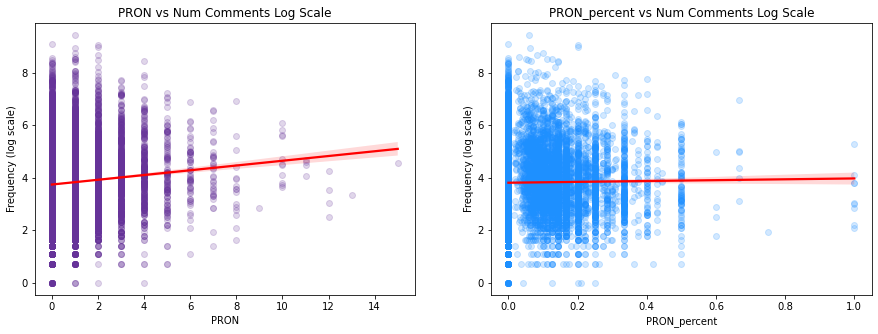

In [61]:
pos_dual_plot('PRON', 'PRON_percent')

**Observation** The number of `PRON` is positively correlated with `num_comments_logscale` while `PRON_percent` is more or less flat. Expect to see `PRON` play a larger part during modeling.

#### Review `PROPN` and `PROPN_percent` (proper noun)

In [62]:
# make sure there is enough density for PROPN
pos_df.PROPN.value_counts(normalize=True)

0     0.643388
1     0.183855
2     0.091509
3     0.038949
4     0.019056
5     0.009318
6     0.006491
7     0.002094
9     0.001152
10    0.001152
8     0.000838
12    0.000733
11    0.000314
16    0.000314
13    0.000209
28    0.000105
15    0.000105
37    0.000105
26    0.000105
14    0.000105
17    0.000105
Name: PROPN, dtype: float64

**Observation** 35% of titles contain at least one PROPN

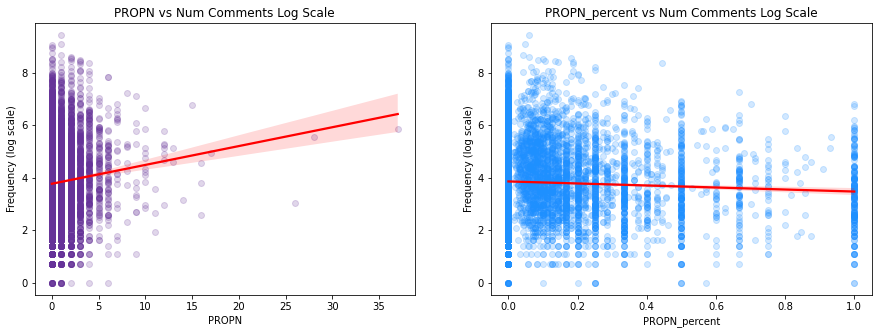

In [63]:
pos_dual_plot('PROPN', 'PROPN_percent')

**Observation** The number of `PROPN` is very positively correlated with `num_comments_logscale` while `PROPN_percent` is slightly negatively correlated. Expect to see `PROPN` play a larger part during modeling.

#### Review `PUNCT` and `PUNCT_percent` (punctuation)

In [64]:
# make sure there is enough density for PUNCT
pos_df.PUNCT.value_counts(normalize=True)

0     0.470003
1     0.254528
2     0.134436
3     0.065229
4     0.032353
5     0.018427
6     0.009737
7     0.006387
8     0.004502
9     0.001675
10    0.001047
12    0.000419
11    0.000419
15    0.000209
14    0.000209
13    0.000209
23    0.000105
18    0.000105
Name: PUNCT, dtype: float64

**Observation** 53% of titles contain at least one PUNCT

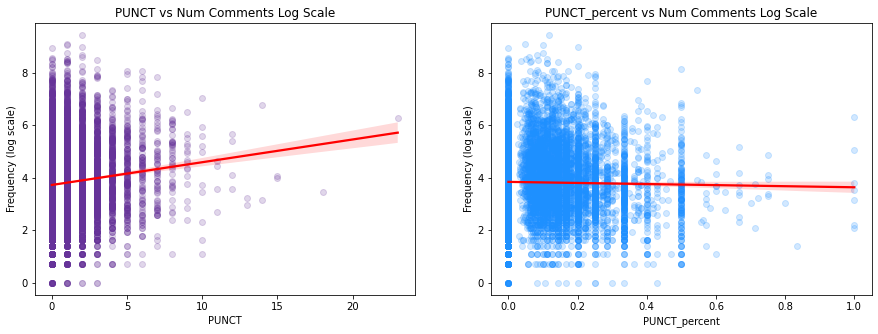

In [65]:
pos_dual_plot('PUNCT', 'PUNCT_percent')

**Observation** The number of `PUNCT` is positively correlated with `num_comments_logscale` while `PUNCT_percent` is slightly negatively correlated. Expect to see `PUNCT` play a larger part during modeling.

#### Review `SCONJ` and `SCONJ_percent` (subordinating conjunction)

In [66]:
# make sure there is enough density for SCONJ
pos_df.SCONJ.value_counts(normalize=True)

0    0.872998
1    0.108052
2    0.015391
3    0.002932
4    0.000419
5    0.000209
Name: SCONJ, dtype: float64

**Observation** 13% of titles contain at least one SCONJ

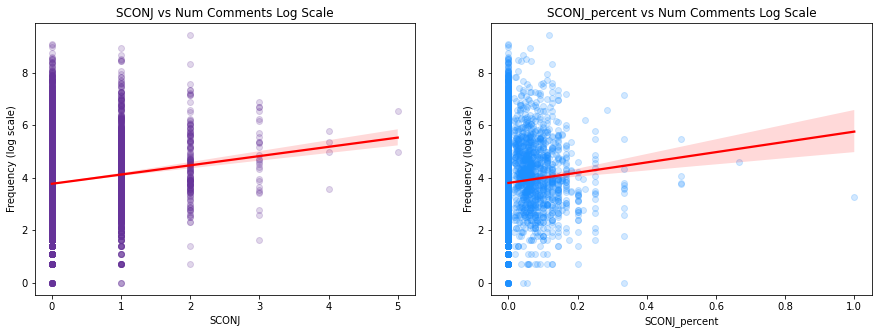

In [67]:
pos_dual_plot('SCONJ', 'SCONJ_percent')

**Observation** The number of `SCONJ` and `SCONJ_percent` are both is positively correlated with `num_comments_logscale`. Both could play a larger part during modeling.

#### Review `SYM` and `SYM_percent` (symbol)

In [68]:
# make sure there is enough density for SYM
pos_df.SYM.value_counts(normalize=True)

0    0.969846
1    0.026803
2    0.002303
3    0.000838
5    0.000105
4    0.000105
Name: SYM, dtype: float64

**Observation** There are not enough non-zeros to keep these variables. Earlier emojis were removed using clean-text, but those didn't have enough penetration either. Drop these.

In [69]:
pos_df.drop(['SYM','SYM_percent'], axis=1, inplace=True)

#### Review `VERB` and `VERB_percent` (verb)

In [70]:
# make sure there is enough density for VERB
pos_df.VERB.value_counts(normalize=True)

0     0.366140
1     0.337137
2     0.166475
3     0.067846
4     0.030782
5     0.016229
6     0.005968
7     0.003979
8     0.002618
9     0.001780
10    0.000524
11    0.000314
12    0.000209
Name: VERB, dtype: float64

**Observation** 73% of titles contain at least one VERB

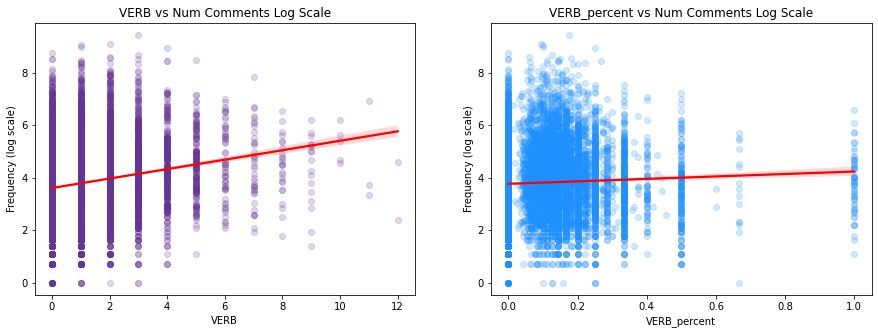

In [71]:
pos_dual_plot('VERB', 'VERB_percent')

**Observation** The number of `VERB` is positively correlated with `num_comments_logscale` while `VERB_percent` is more or less flat. Expect to see `VERB` play a larger part during modeling.

#### Review `X` and `X_percent` (other)

In [72]:
# make sure there is enough density for X
pos_df.X.value_counts(normalize=True)

0    0.946707
1    0.027850
3    0.012041
2    0.011727
4    0.000733
5    0.000419
6    0.000314
8    0.000209
Name: X, dtype: float64

**Observation** Nearly 95% of titles do not contain an `X` pos. Drop.

In [73]:
pos_df.drop(['X','X_percent'], axis=1, inplace=True)

#### A final note on POS

In the above exploratory analysis, some parts-of-speech distributions and correlations with `num_comments` did not seem incredibly strong, but they were left in to better understand their effect during feature selection.

## NLP - TF-IDF

### Train-Test Split Data

In [74]:
# split the data
# use 20% because it is similar to using 5 folds

X_train, X_test = train_test_split(titles['title'],
                     test_size = 0.20,
                     shuffle = True,
                     random_state = 21)

In [75]:
# rename X_train to is_train for joining
X_train.rename('is_train', inplace=True);

In [76]:
# join is_train to titles to encode the train set
titles = titles.join(X_train)

In [77]:
# convert to int encode is_train as a variable that
# is 1 for the train set and 0 for the test set
titles.is_train = titles.is_train.map(lambda x: pd.isnull(x)).astype(int)

**Note** the reason for this method of train-test is so we can continue to export the train-test segments into csv files for other notebooks in this project.

### No Stem, No Lemma

The first approach for our NLP will be to TF-IDF vectorize the titles without performing any stemming or lemmatization methods.

In [78]:
# instantiate a tfidf vectorizer
tvec = TfidfVectorizer(
                       stop_words = 'english',
                       strip_accents = 'ascii',
                       max_features = 200,
                       max_df = .60,
                       norm = 'l2'
        )

# fit our vectorizer with our train
tvec.fit(titles[titles.is_train==1].title)

# create tfidf matrix with our entire dataset
tvec_naut = pd.DataFrame(tvec.transform(titles['title']).todense(),
                           columns = tvec.get_feature_names())

In [79]:
# take a peak at the first 10
tvec_naut.columns[:10]

Index(['000', '10', '2022', '40', 'actual', 'ago', 'air', 'amazing', 'america',
       'anon'],
      dtype='object')

### Porter Stem

The second approach for our NLP will be to TF-IDF vectorize the titles after stemming.

In [80]:
# intialize stemmer
ps = PorterStemmer()

In [81]:
# create stem titles
title_stemmed = [' '.join([ps.stem(w.text) for w in nlp(t)])
                           for t in titles['title']]


# join to titles
titles['title_stemmed'] = title_stemmed

In [82]:
# instantiate a tfidf vectorizer
tvec = TfidfVectorizer(
                       stop_words = 'english',
                       strip_accents = 'ascii',
                       max_features = 200,
                       max_df = .60,
                       norm = 'l2'
        )

# fit our vectorizer with our train
tvec.fit(titles[titles.is_train==1].title_stemmed)

# create tfidf matrix with our entire dataset
tvec_stem = pd.DataFrame(tvec.transform(titles['title_stemmed']).todense(),
                           columns = tvec.get_feature_names())

In [83]:
# take a peak at the first 10
tvec_stem.columns[:10]

Index(['000', '10', '2022', '40', 'actual', 'age', 'ago', 'air', 'alway',
       'amaz'],
      dtype='object')

In [84]:
# remove '10', '40', '000' because it could be any number due to stemming
# keep '2022' because of the high likelihood of being a year
tvec_stem.drop(['000','10','40'], axis=1, inplace=True)

### Lemmatize

The third approach for our NLP will be to TF-IDF vectorize the titles after lemmatization.

In [85]:
title_lemma = [' '.join([w.lemma_ for w in nlp(t)])
                           for t in titles['title']]

# join to titles
titles['title_lemma'] = title_lemma

In [86]:
# instantiate a tfidf vectorizer
tvec = TfidfVectorizer(
                       stop_words = 'english',
                       strip_accents = 'ascii',
                       max_features = 200,
                       max_df = .60,
                       norm = 'l2'
        )

# fit our vectorizer with our train
tvec.fit(titles[titles.is_train==1].title_lemma)

# create tfidf matrix with our entire dataset
tvec_lemma = pd.DataFrame(tvec.transform(titles['title_lemma']).todense(),
                           columns = tvec.get_feature_names())

In [87]:
# take a peak at the first 10
tvec_lemma.columns[0:10]

Index(['000', '10', '2022', '40', 'actual', 'ago', 'air', 'amazing', 'anon',
       'art'],
      dtype='object')

**Observation** Keep 000, 10, 40 because they are the original values and may have value.

### Lemmatize and Stem

The fourth approach for our NLP will be to TF-IDF vectorize the titles after lemmatizing the stem.

In [88]:
title_lem_stem = [' '.join([ps.stem(w.text) for w in nlp(t)])
                           for t in titles.title_lemma]

# join to titles
titles['title_lem_stem'] = title_lem_stem

In [89]:
# instantiate a tfidf vectorizer
tvec = TfidfVectorizer(
                       stop_words = 'english',
                       strip_accents = 'ascii',
                       max_features = 200,
                       max_df = .60,
                       norm = 'l2'
        )

# fit our vectorizer with our train
tvec.fit(titles[titles.is_train==1].title_lem_stem)

# create tfidf matrix with our entire dataset
tvec_lem_stem = pd.DataFrame(tvec.transform(titles['title_lem_stem']).todense(),
                           columns = tvec.get_feature_names())

In [90]:
# take a peak at the first 10
tvec_lem_stem.columns[0:10]

Index(['000', '10', '2022', '40', 'actual', 'age', 'ago', 'air', 'alway',
       'amaz'],
      dtype='object')

In [91]:
# remove '10', '40', '000' because it could be any number due to stemming
# keep '2022' because of the high likelihood of being a year
tvec_lem_stem.drop(['000','10','40'], axis=1, inplace=True)

### A final note on NLP - TF-IDF

Further analysis can be done to see the impact of what changing the number of max features and max_df in the tfidfvectorizers has on our modeling. 200 was used for max_features because it provided enough insight into our titles without flooding our models with too much additional data.

## Produce output files

In [92]:
# create new dataframe of just the new things added to our titles dataframe
scrape_nlp = titles[['polarity','subjectivity','number_of_emoji','is_train']]

# join this dataframe with our parts of speech dataframe
scrape_nlp = scrape_nlp.join(pos_df)

# remove targets and sum_pos which is duplicative with our pos columns
scrape_nlp.drop(['sum_pos','num_comments','num_comments_logscale','target'],
                axis = 1,
                inplace=True);

In [93]:
# create four scrape_nlp files for each tf-idf framework
scrape_nlp_naut = scrape_nlp.join(tvec_naut)
scrape_nlp_stem = scrape_nlp.join(tvec_stem)
scrape_nlp_lemma = scrape_nlp.join(tvec_lemma)
scrape_nlp_lem_stem = scrape_nlp.join(tvec_lem_stem)

### Add back remaining attributes from scrapes

In [94]:
# add everything else from scrapes except title which we no longer need
scrape_nlp_naut = scrape.drop('title', axis=1).join(scrape_nlp_naut)
scrape_nlp_stem = scrape.drop('title', axis=1).join(scrape_nlp_stem)
scrape_nlp_lemma = scrape.drop('title', axis=1).join(scrape_nlp_lemma)
scrape_nlp_lem_stem = scrape.drop('title', axis=1).join(scrape_nlp_lem_stem)

### Save and Export

In [95]:
scrape_nlp_naut.to_csv('../data/nlp_naut_data.csv', index = False)
scrape_nlp_stem.to_csv('../data/nlp_stem_data.csv', index = False)
scrape_nlp_lemma.to_csv('../data/nlp_lemma_data.csv', index = False)
scrape_nlp_lem_stem.to_csv('../data/nlp_lem_stem_data.csv', index = False)